In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This notebook is prepared for kaggle competition "https://www.kaggle.com/c/alaska2-image-steganalysis"

# What is Stegnography?

Steganography is the technique of hiding secret data within an ordinary, non-secret, file or message in order to avoid detection; the secret data is then extracted at its destination. The use of steganography can be combined with encryption as an extra step for hiding or protecting data. The word steganography is derived from the Greek words steganos (meaning hidden or covered) and the Greek root graph (meaning to write).

For more details please see : https://en.wikipedia.org/wiki/Steganography


In this notebook we are going to explore 3,00,000 images.

* 75,000 original images
* 75,000 images with JUNIWARD stegnography
* 75,000 images with JMiPOD stegnography
* 75,000 images with UERD stegnography

**Using these 3,00,000 images our goal is the train a model which can classify if image has any hidden message or not.**

In [1]:
#install jpegio
# ! git clone https://github.com/hellyjain/jpegio
# Once downloaded install the package
# !pip install jpegio/.
!pip install -q efficientnet

In [2]:
import os
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import train_test_split
# import jpegio as jpio
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import gc

# Defining some functions to explore the images and compare the original image (cover) with image having hidden data. 

In [3]:
#compare cover with corresponding stegnograph picture


def compare_steg(image):    
    fig, ax = plt.subplots(nrows= 3, ncols = 3, figsize = (22,17))
    steg = ['JMiPOD', 'JUNIWARD', 'UERD']
    cover = cv2.imread('/kaggle/input/alaska2-image-steganalysis/Cover/'+image)
    for r in range(3):
        coded = cv2.imread('/kaggle/input/alaska2-image-steganalysis/'+str(steg[r])+'/'+image)
        for c in range(3):
            ax[r][1].set_title(steg[r])
            ax[r][0].imshow(cover)
            ax[r][0].axis('off')
            ax[r][1].imshow(coded)
            ax[r][1].axis('off')
            ax[r][2].imshow(cover - coded)
            ax[r][2].axis('off')

            
#Lets do pixel by pixel comparision of raw matrix

def pixel_summary(image):
    cover = cv2.imread('/kaggle/input/alaska2-image-steganalysis/Cover/'+image)
    JMiPOD = cv2.imread('/kaggle/input/alaska2-image-steganalysis/JMiPOD/'+image)
    JUNIWARD = cv2.imread('/kaggle/input/alaska2-image-steganalysis/JUNIWARD/'+image)
    UERD = cv2.imread('/kaggle/input/alaska2-image-steganalysis/UERD/'+image)
    u_cover = np.unique(cover.reshape(512*512,3), axis =0).shape
    u_JMiPOD = np.unique(JMiPOD.reshape(512*512,3), axis =0).shape
#     d_JMiPOD = np.unique((cover - JMiPOD).reshape(512*512,3), axis =0).shape
    u_JUNIWARD = np.unique(JUNIWARD.reshape(512*512,3), axis =0).shape
#     d_JUNIWARD = np.unique((cover - JUNIWARD).reshape(512*512,3), axis =0).shape
    u_UERD = np.unique(UERD.reshape(512*512,3), axis =0).shape
#     d_UERD = np.unique((cover - UERD).reshape(512*512,3), axis =0).shape
    print('Total unique colors in original image : {}'.format(u_cover[0]))
    print('Total unique colors in JMiPOD image : {}'.format(u_JMiPOD[0]))
#     print('Change in colors comparing Original vs JMiPOD image : {}'.format((d_JMiPOD)[0]))
    print('Total unique colors in JUNIWARD image : {}'.format(u_JUNIWARD[0]))
#     print('Change in colors comparing Original vs JUNIWARD image : {}'.format((d_JUNIWARD)[0]))
    print('Total unique colors in UERD image : {}'.format(u_UERD[0]))
#     print('Change in colors comparing Original vs UERD image : {}'.format((d_UERD)[0]))

**Cover image on left,    loaded image in the middle,    pixel differences on the right**

Total unique colors in original image : 59570
Total unique colors in JMiPOD image : 59642
Total unique colors in JUNIWARD image : 59633
Total unique colors in UERD image : 59663


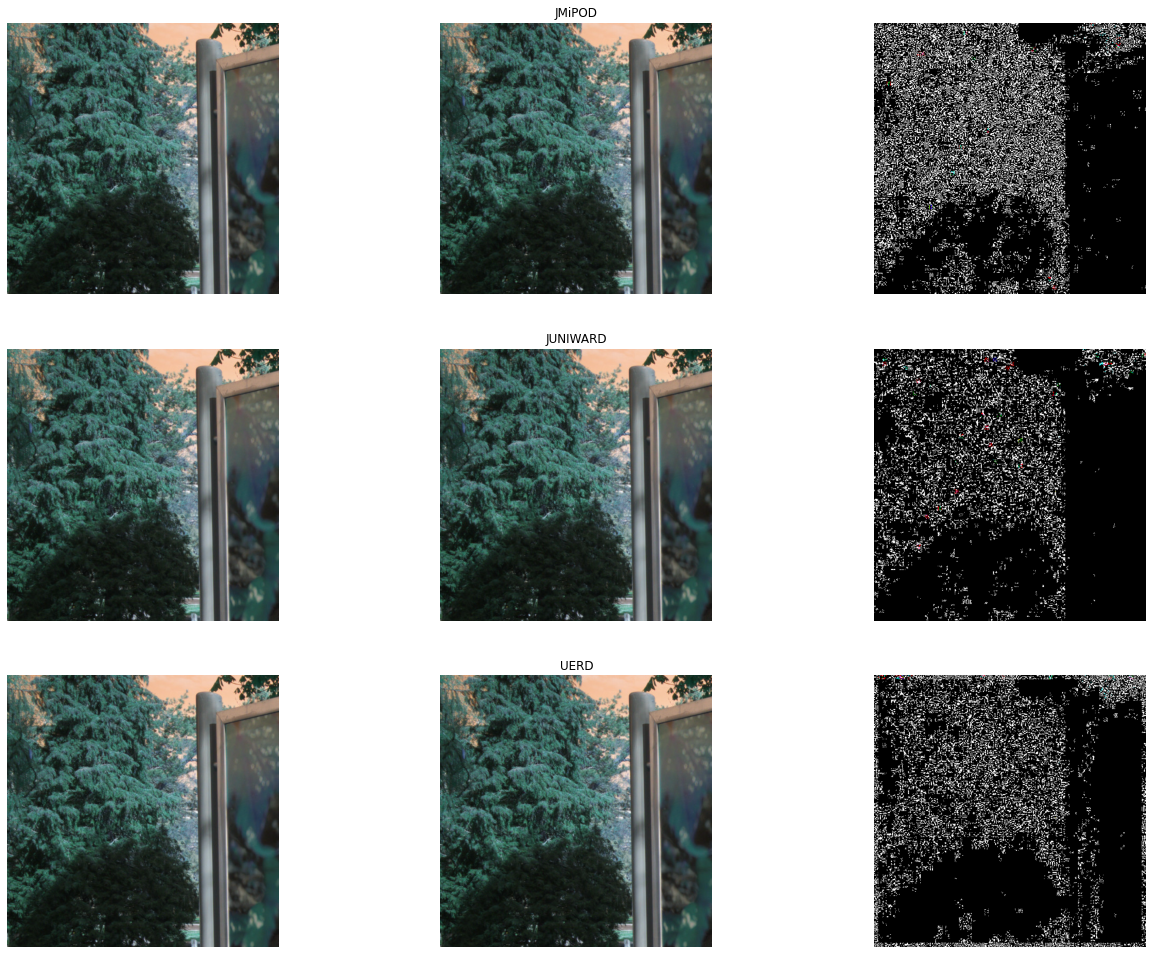

In [4]:
compare_steg('00001.jpg')
pixel_summary('00001.jpg')

Total unique colors in original image : 11254
Total unique colors in JMiPOD image : 11256
Total unique colors in JUNIWARD image : 11253
Total unique colors in UERD image : 11253


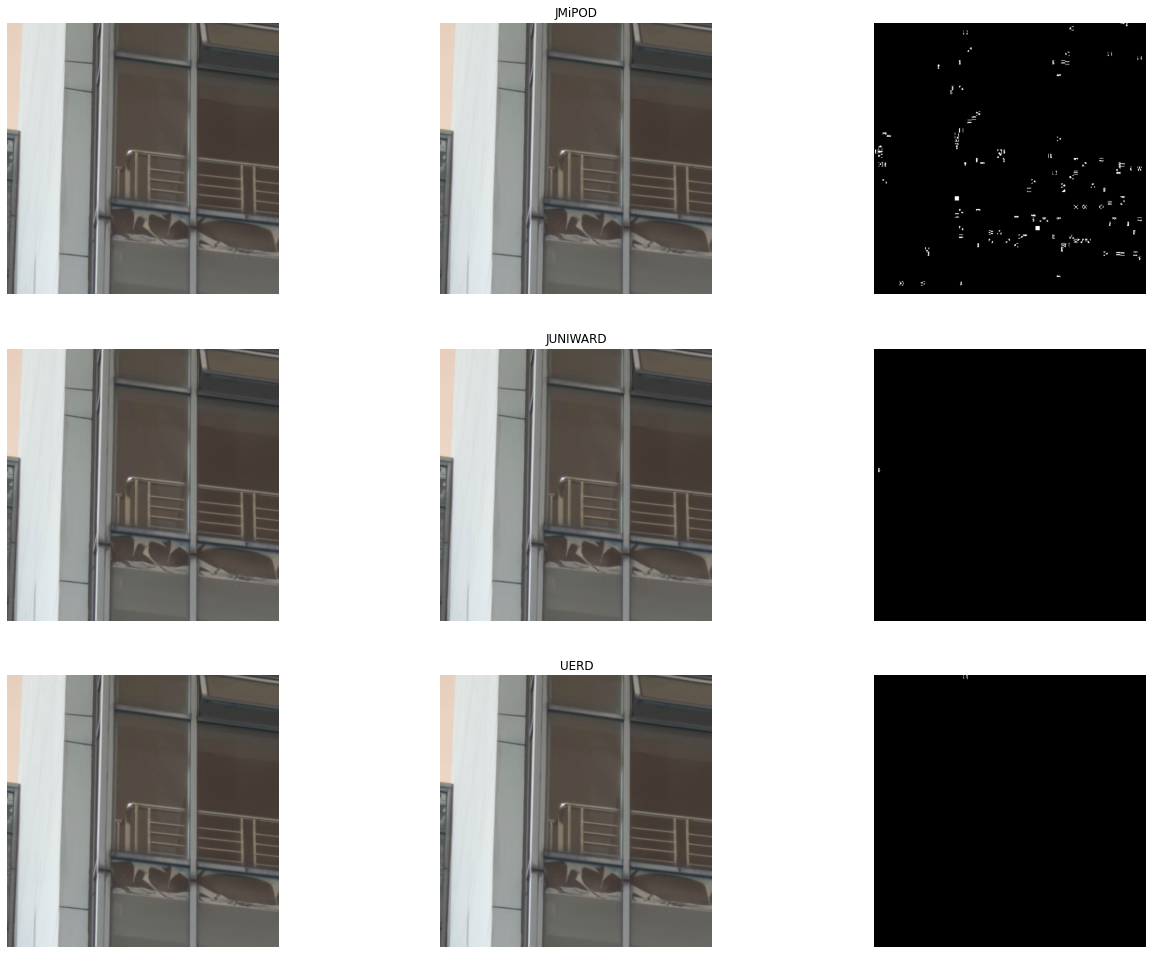

In [5]:
compare_steg('00501.jpg')
pixel_summary('00501.jpg')

Total unique colors in original image : 31737
Total unique colors in JMiPOD image : 31797
Total unique colors in JUNIWARD image : 31746
Total unique colors in UERD image : 31747


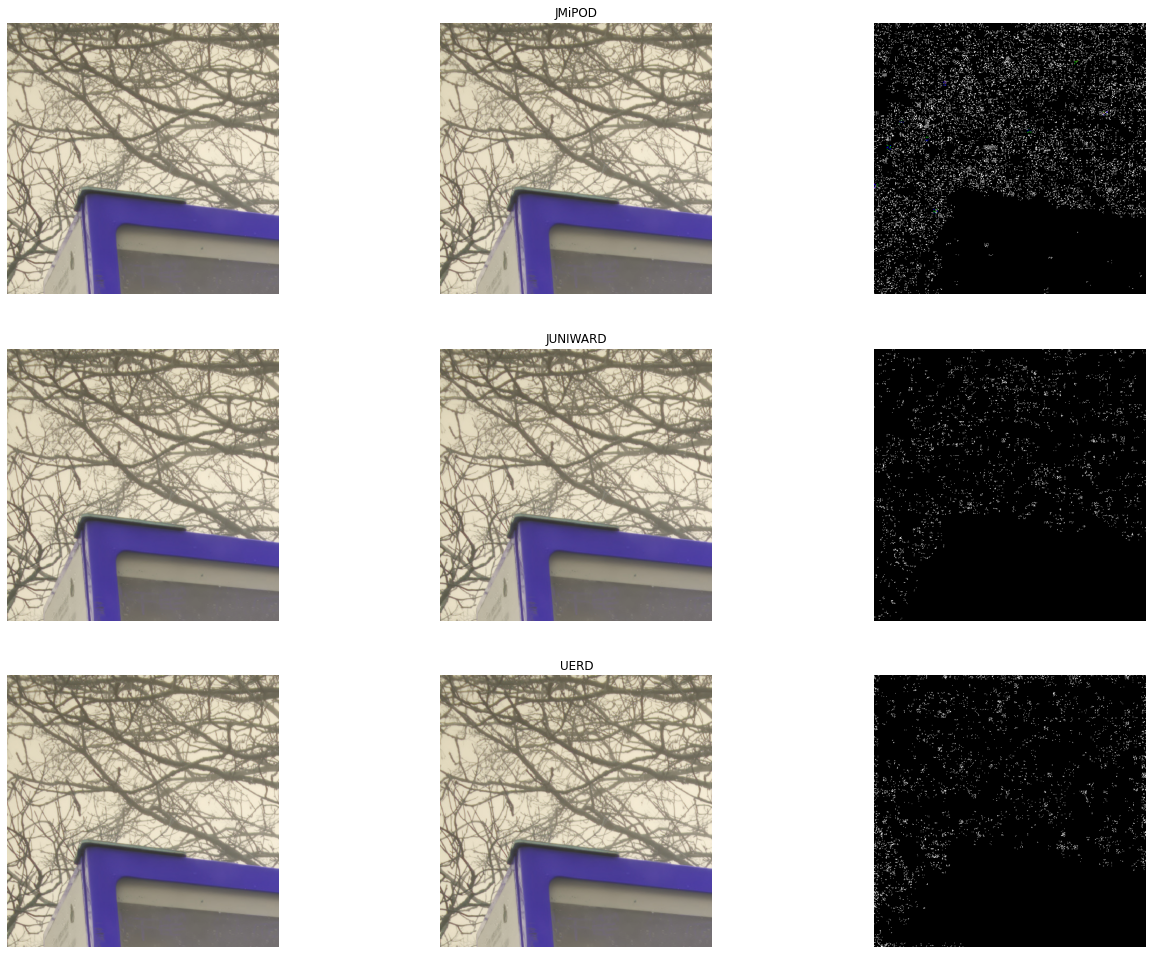

In [6]:
compare_steg('01011.jpg')
pixel_summary('01011.jpg')

Total unique colors in original image : 156219
Total unique colors in JMiPOD image : 157851
Total unique colors in JUNIWARD image : 156840
Total unique colors in UERD image : 156466


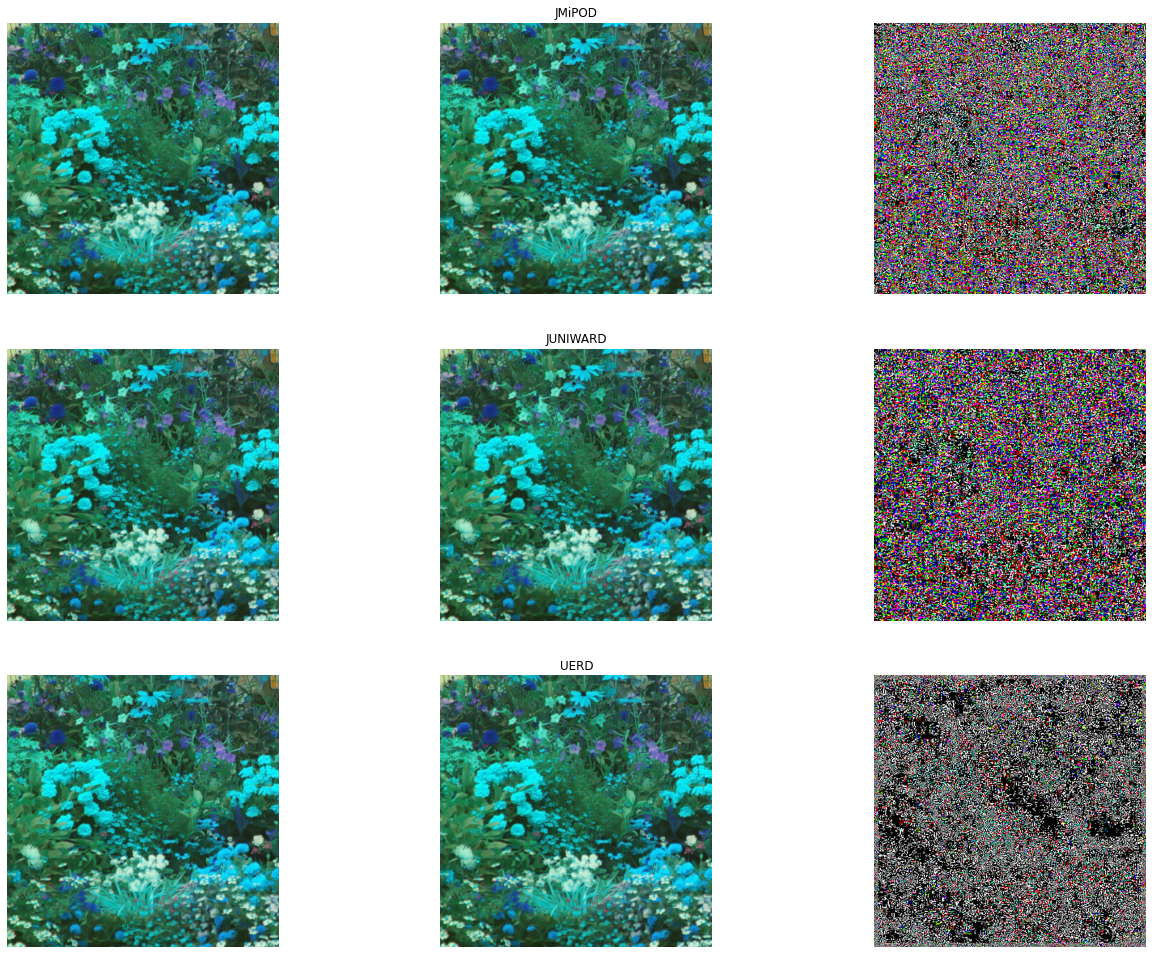

In [7]:
compare_steg('62001.jpg')
pixel_summary('62001.jpg')

# **Invoing TPU**

In [8]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [9]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('alaska2-image-steganalysis')

# Configuration
# EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync * 2

In [10]:
GCS_DS_PATH

'gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3b51f73e9e96b81f109a'

Defining functions to read / format the images to feed to Keras

In [11]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label
    
# def decode_image_YCbCr(filename, label=None, image_size=(512, 512)):
# #     bits = tf.io.read_file(filename)
#     image = JPEGdecompressYCbCr_v3(filename)
#     image = tf.cast(image, tf.float32) / 256.0
#     image = tf.image.resize(image, image_size)
    
#     if label is None:
#         return image
#     else:
#         return image, label

# def data_augment(image, label=None):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    
#     if label is None:
#         return image
#     else:
#         return image, label

Defining Efficientnet B5 model

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([efn.EfficientNetB5(input_shape=(512, 512, 3),weights='imagenet',include_top=False)
                             ,L.GlobalAveragePooling2D()
                            ,L.Dense(10, activation='softmax')])
    model.compile(optimizer='adamax', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

**Splitting the 3,00,000 images into 10 batches to avoid memory exception.**

In [16]:
train = pd.read_csv('/kaggle/input/training/input_batch.csv')
train['imagepath'] = train.imagepath.str.replace('gs://kds-cd794677eb4416f86e3e23278e2d1f1e37783bc29e7982b08d469689',
                        GCS_DS_PATH, regex = True)
train.head()

Unnamed: 0                                          imagepath  imagename  \
0           0  gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3...  77231.jpg   
1           1  gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3...  32130.jpg   
2           2  gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3...  31619.jpg   
3           3  gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3...  67721.jpg   
4           4  gs://kds-d7606dbfd8ee47349bbbb9988a9e87859e3b3...  11242.jpg   

   label  batch                                      imagepath_gpu  \
0      0      9  /kaggle/input/alaska2-image-steganalysis/Cover...   
1      0      4  /kaggle/input/alaska2-image-steganalysis/Cover...   
2      0      3  /kaggle/input/alaska2-image-steganalysis/Cover...   
3      0      8  /kaggle/input/alaska2-image-steganalysis/Cover...   
4      0      1  /kaggle/input/alaska2-image-steganalysis/Cover...   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN          NaN          NaN   

   Unnamed: 12  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

Training the model on one batch for now.

In [ ]:
for i in tqdm(range(5,6)):
    train_paths = train[train['batch'] == i]['imagepath']
    train_lables = train[train['batch'] == i]['label']
    train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_lables, test_size=0.20, random_state=619)
    train_dataset = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(decode_image, num_parallel_calls=AUTO).cache().repeat().shuffle(1024).batch(BATCH_SIZE).prefetch(AUTO))
    valid_dataset = (tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels)).map(decode_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).cache().prefetch(AUTO))
    STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
    history = model.fit(train_dataset, epochs=10, batch_size = BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valid_dataset)
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/10


In [ ]:
#Read the test images

def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

submission = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
test_paths = append_path('Test')(submission.Id.values)

In [ ]:
#create submission file

test_dataset = (tf.data.Dataset.from_tensor_slices(test_paths).map(decode_image, num_parallel_calls=AUTO).batch(BATCH_SIZE))
lab = model.predict(test_dataset, verbose=1)
submission.Label = 1-lab[:,[0]]
submission.to_csv('submission_ALASKA.csv', index=False)

In [ ]:
#Save model weights and use them while training other batches of images

model.save_weights("model_b5.h5")
# model.load_weights("model_b5.h5")